# Imports

In [ ]:
import numpy as np
import pandas as pd

# ML Libs
import sklearn
import tensorflow as tf
from tensorflow import keras

# Data Viz
import matplotlib.pyplot as plt

# Load the Data

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=False)  # do not shuffle the data right now

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
# This is a classification dataset, but we will primarily be using this for generation
X = dataset["data"]
y = dataset["target"]

DATASET_DESCRIPTION = dataset["DESCR"]
print(DATASET_DESCRIPTION)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

# Explore the Data

In [ ]:
X.shape

(400, 4096)

In [ ]:
y.shape

(400,)

In [ ]:
# First few examples of X
X[:5]

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       [0.1983471 , 0.19421488, 0.19421488, ..., 0.75206614, 0.75206614,
        0.73966944],
       [0.5       , 0.54545456, 0.58264464, ..., 0.17768595, 0.17355372,
        0.17355372]], dtype=float32)

In [ ]:
# First 24 labels of y
y[:24]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2])

In [ ]:
# Detective Work (optional read)

# So, already we know even without reading the description that there are 400 examples in this dataset
# We already know that this dataset is comprised of faces from AT&T in 1992
# X represents all the examples of each face (so the actual set of data without the labels). Each example is a flattened 64x64 pixel face, hence the dimensionality of 4096
# y represents the label for each face (which face it is). According to the description, since there are 40 classes, there are 40 possible faces to recognize, and 10 examples per face
NUM_CLASSES = 40
EXAMPLES_PER_CLASS = 10
IMG_DIM = 64

# Let's put this image data in 2D instead of 1D
X_img = X.reshape(-1, IMG_DIM, IMG_DIM)  # we could've also just done `X_img = dataset["images"]`, but datasets won't always be so accommodating, so we are doing it manually

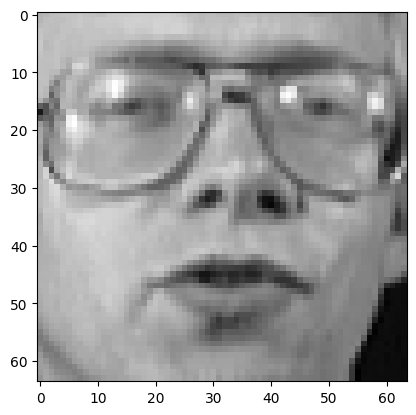

In [ ]:
# Now, let's actually take a look at each face
# Feel free to keep running this cell and switching the index to check the faces
INDEX_OF_FACE_YOU_WANT_TO_SEE = 15
plt.imshow(X_img[INDEX_OF_FACE_YOU_WANT_TO_SEE], cmap="gray")

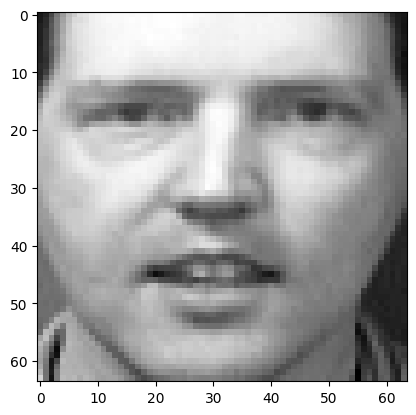

In [ ]:
# Or... you could also see a random face if you can't choose
def see_random_face():
  rand_index = int(np.random.rand() * len(X_img))

  plt.imshow(X_img[rand_index], cmap="gray")

see_random_face()

In [ ]:
# Oftentimes, we want to see more than one at a time and from multiple different people. That's not guaranteed by randomness
# Good thing the data is formatted conveniently for us by having all the data of the same class next to each other (this is why we didn't shuffle the data)!
X_img_per_class = []
y_per_class = []
for label_index in range(NUM_CLASSES):
  lower_bound = label_index * EXAMPLES_PER_CLASS
  X_img_per_class.append([X_img[i] for i in range(lower_bound, lower_bound + EXAMPLES_PER_CLASS)])
  y_per_class.append([label_index] * EXAMPLES_PER_CLASS)

# put to numpy ndarray
X_img_per_class = np.array(X_img_per_class)
y_per_class = np.array(y_per_class)

# Now let's plot by face (face 0 to face 39; 40 labels/faces)
def plot_by_face(label: int, rows: int, cols: int):
  f, axarr = plt.subplots(rows, cols)
  for row in range(rows):
      for col in range(cols):
          sample_index = int(np.random.rand() * EXAMPLES_PER_CLASS)
          axarr[row, col].imshow(X_img_per_class[label][sample_index], cmap="gray")

def plot_faces_by_row(labels, cols: int):
    f, axarr = plt.subplots(len(labels), cols)
    row = 0
    for label in labels:
        for col in range(cols):
            axarr[row, col].imshow(X_img_per_class[label][col], cmap="gray")

        row += 1

def plot_faces_random(num_labels: int, examples_per_label: int):
    plot_faces_by_row(np.random.randint(NUM_CLASSES, size=num_labels), examples_per_label)

In [ ]:
# (NUM_CLASSES, EXAMPLES_PER_CLASS, IMG_DIM, IMG_DIM)
X_img_per_class.shape

(40, 10, 64, 64)

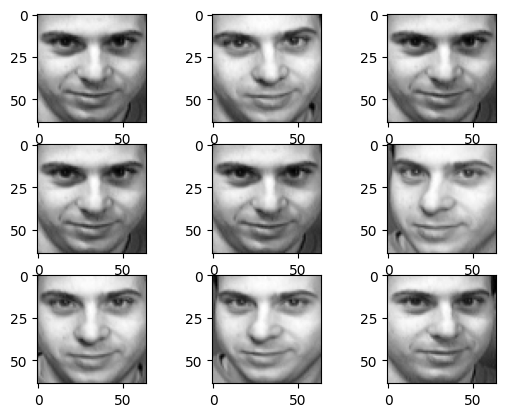

In [ ]:
# Time to really explore the data!
# Play with this to your heart's content!

face_label = 8  # any face from 0 to 39
plot_by_face(face_label, rows=3, cols=3)

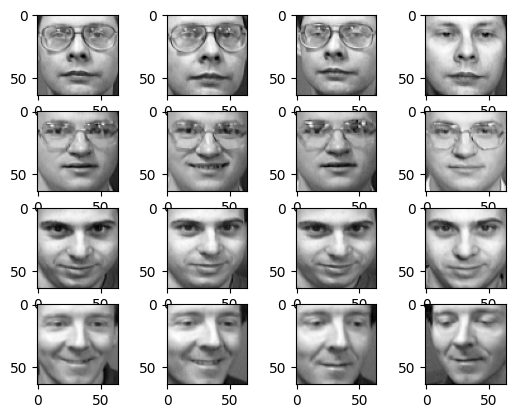

In [ ]:
# Each row will have a different person's face
face_labels = [3, 5, 8, 2]
plot_faces_by_row(face_labels, cols=len(face_labels))  # squares look more visually appealing

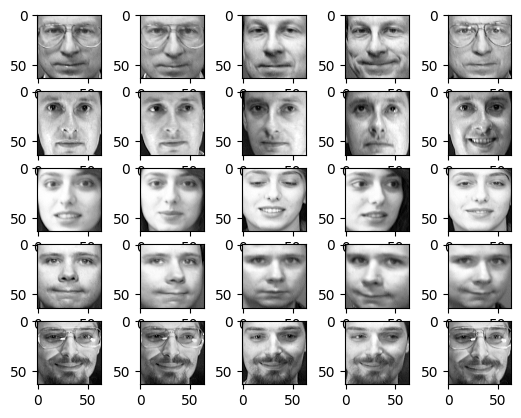

In [ ]:
# Now, let's get a random sample
# Feel free to keep replaying this
(rows, cols) = (5, 5)
plot_faces_random(num_labels=rows, examples_per_label=cols)

# Clustering, Image Segmentation

In [ ]:
import scipy
from sklearn.cluster import KMeans, DBSCAN

MODE_KMEANS = 0
MODE_DBSCAN = 1

OUTLIER_CLUSTER_AVERAGE = 0.0
# KMeans fitting = cluster centers converged through random initialization of location then loop of mean of its members then all clusters reregistering their members

def segment_image_kmeans(image: np.ndarray, n_clusters=4, n_init=10):
  image_1D = image.reshape(-1, 1)
  clusterer = KMeans(n_clusters=n_clusters, n_init=n_init)
  clusterer.fit(image_1D)

  segmented_image = clusterer.cluster_centers_[clusterer.labels_].reshape(image.shape)

  return segmented_image

def segment_image_dbscan(image: np.ndarray, neighborhood=0.5, min_samples=5, neighborhood_in_z_score=False):
  image_1D = image.reshape(-1, 1)
  clusterer = DBSCAN(eps=neighborhood, min_samples=min_samples)
  clusterer.fit(image_1D)

  cluster_sums = np.array([0.] * len(image_1D)).reshape(-1, 1)
  cluster_counts = np.array([0] * len(image_1D)).reshape(-1, 1)
  for (i, cluster) in enumerate(clusterer.labels_):
    if cluster != -1:
      cluster_sums[cluster] += image_1D[i]
      cluster_counts[cluster] += 1

  # outlier slot
  end_index = np.argwhere(cluster_counts == 0).ravel()[0]

  # cut the lists short: only the clusters that exist + the outlier slot
  cluster_sums = cluster_sums[:end_index+1]
  cluster_counts = cluster_counts[:end_index+1]
  cluster_counts[-1] = 1  # for stable division

  # average it up
  cluster_averages = cluster_sums / cluster_counts

  # put it in z-scores if allowed
  if neighborhood_in_z_score:
    cluster_averages = (cluster_averages - np.mean(image_1D)) / np.std(image_1D)

  # set the outlier intensity
  cluster_averages[-1] = OUTLIER_CLUSTER_AVERAGE
  outlier_index = len(cluster_averages) - 1

  print(cluster_averages)

  # replace the outlier labels with the designated outlier_index
  cluster_labels = np.array([(outlier_index if cluster == -1 else cluster) for cluster in clusterer.labels_])

  segmented_image = cluster_averages[cluster_labels].reshape(image.shape)

  return segmented_image

def plot_segmented_image(image: np.ndarray, segmentation_mode=MODE_KMEANS, cmap="gray", **kwargs):
  image_segmented = None
  if segmentation_mode == MODE_DBSCAN:
    image_segmented = segment_image_dbscan(image, **kwargs)
  else:
    image_segmented = segment_image_kmeans(image, **kwargs)

  #print(image_segmented)

  plt.imshow(image_segmented, cmap=cmap)

# cluster_labels is like the face_labels where it is and int list. Order matters, but cannot have duplicate values
def plot_clusters(clusterer, images: np.ndarray, cluster_labels, max_col=5, cmap="gray"):
  #num_images = images.shape[0]
  #img_dims = images.shape[1:]
  images_clusters = clusterer.fit_predict(images)

  rows = len(cluster_labels)
  cols = np.min([max_col, scipy.stats.mode(images_clusters).count])
  f, axarr = plt.subplots(rows, cols)

  available_cols = [0] * rows
  for (i, cluster) in enumerate(images_clusters):
    #print(f"cluster_labels: {cluster_labels}\ncluster: {cluster}")
    row = np.argwhere(cluster_labels == cluster).ravel()

    if len(row) == 0:  # empty
      continue

    # there is a match; no duplicates; squeeze
    row = row[0]

    col = available_cols[row]

    if col >= max_col:
      continue

    axarr[row, col].imshow(images[i].reshape(IMG_DIM, IMG_DIM), cmap=cmap)
    available_cols[row] += 1  # now that the column is taken

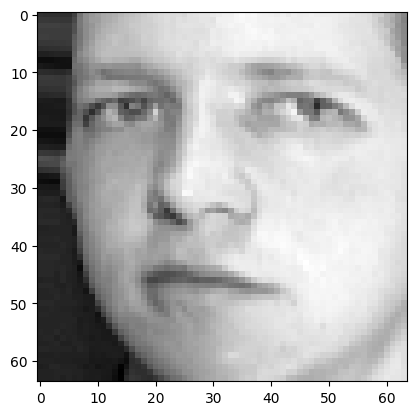

In [ ]:
INDEX_OF_FACE_YOU_WANT_TO_SEE = 3
plt.imshow(X_img[INDEX_OF_FACE_YOU_WANT_TO_SEE], cmap="gray")

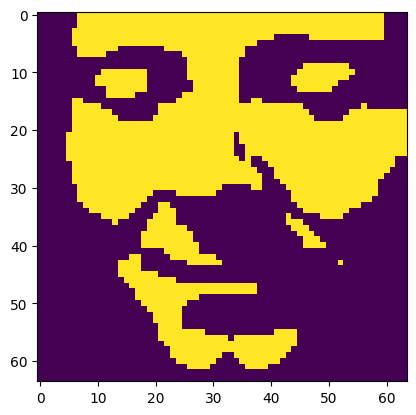

In [ ]:
# Here are some things to try:
# Modify n_clusters and see what happens
# Take away the cmap="gray"
# Replace "gray" (in cmap="gray") with one of the following (your choice):
"""
'viridis', 'plasma', 'inferno', 'magma', 'cividis',
'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral', 'gist_ncar',
'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
'hot', 'afmhot', 'gist_heat', 'copper',
'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn',
'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
'twilight', 'twilight_shifted', 'hsv',
'Pastel1', 'Pastel2', 'Paired', 'Accent',
'Dark2', 'Set1', 'Set2', 'Set3',
'tab10', 'tab20', 'tab20b', 'tab20c'
"""
INDEX_OF_FACE_YOU_WANT_TO_SEE = 23
image = X_img[INDEX_OF_FACE_YOU_WANT_TO_SEE]
plot_segmented_image(image, segmentation_mode=MODE_KMEANS, n_clusters=2, cmap="viridis")  #plt.imshow(segment_image_kmeans(X_img[INDEX_OF_FACE_YOU_WANT_TO_SEE], n_clusters=4), cmap="gray")

[[0.72359944]
 [0.        ]]


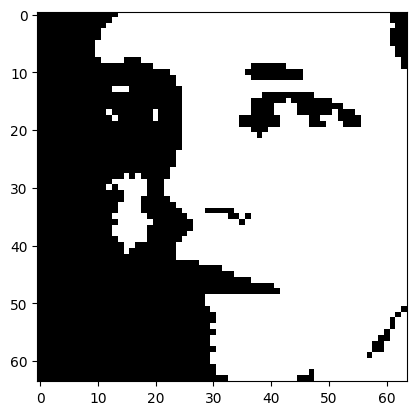

In [ ]:
# Try the same things here too!
# But this time, mess around with neighborhood and min_samples and see what happens!
# Remember, you can go up to 4096 on min_samples!

INDEX_OF_FACE_YOU_WANT_TO_SEE = 3
image = X_img[INDEX_OF_FACE_YOU_WANT_TO_SEE]
plot_segmented_image(image, segmentation_mode=MODE_DBSCAN, neighborhood=0.075, min_samples=1250, cmap="gray")  #plt.imshow(segment_image_dbscan(X_img[INDEX_OF_FACE_YOU_WANT_TO_SEE], neighborhood=0.5, min_samples=5), cmap="gray")

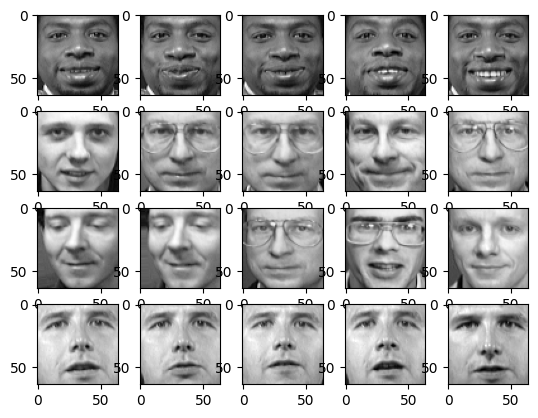

In [ ]:
# With KMeans

# Let's see how well it does with NUM_CLASSES clusters!
kmeans = KMeans(n_clusters=NUM_CLASSES, n_init=10)
plot_clusters(kmeans, X, [1, 3, 5, 7])

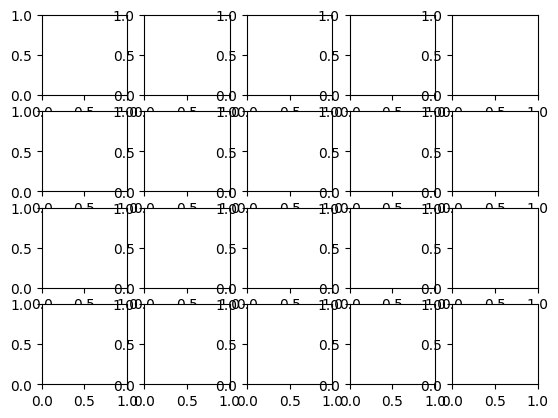

In [ ]:
# With DBSCAN

# Let's see how well it does with DBSCAN!
dbscan = DBSCAN(eps=0.5, min_samples=100)
plot_clusters(dbscan, X, [1, 3, 5, 7])

# Classification (Facial Recognition)

In [ ]:
# More imports
import xgboost

In [ ]:
# README: Dataset splitting; just run and ignore this

from sklearn.model_selection import train_test_split

# data shape is (partitions, examples per partition, ...data)
# returned data shape is (m, ...data)
# assumes partitioning by label
def stratified_train_val_test_split(X_partitioned: np.ndarray, y_partitioned: np.ndarray, ideal_ratio: float, test_ratio=0.5):
  (num_partitions, examples_per_partition) = (X_partitioned.shape[0], X_partitioned.shape[1])
  #m = num_partitions * examples_per_partition

  train_set = (None, None)
  val_set = (None, None)
  test_set = (None, None)

  def amass(pair: tuple, target: tuple):
    (Xp, yp) = pair
    (Xt, yt) = target
    if Xt is None or yt is None:
        target = pair
    else:
        target = (np.append(Xt, Xp, axis=0), np.append(yt, yp, axis=0))

    return target

  for partition in range(num_partitions):
    (X_partition, y_partition) = (X_partitioned[partition], y_partitioned[partition])

    # shuffle & distribute partition between train, val, and test sets
    (X_train_part, X_ideal_part, y_train_part, y_ideal_part) = train_test_split(X_partition, y_partition, test_size=ideal_ratio)
    (X_val_part, X_test_part, y_val_part, y_test_part) = train_test_split(X_ideal_part, y_ideal_part, test_size=test_ratio)

    train_set = amass((X_train_part, y_train_part), train_set)
    val_set = amass((X_val_part, y_val_part), val_set)
    test_set = amass((X_test_part, y_test_part), test_set)

  return {
      "train": train_set,
      "validation": val_set,
      "test": test_set
  }

datasets = stratified_train_val_test_split(X_img_per_class, y_per_class, ideal_ratio=0.2)

(X_train, y_train) = datasets["train"]
(X_val, y_val) = datasets["validation"]
(X_test, y_test) = datasets["test"]

m_train = len(y_train)
m_val = len(y_val)
m_test = len(y_test)

print(m_train)
print(m_val)
print(m_test)

320
40
40


### Using a Gradient-Boosted Ensemble

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# hyperparameters; don't worry about these; maybe change n_estimators if you want? that's the most important one
# there's also learning_rate if you wanna mess with that too. If you are familiar with neural networks, this is NOT the same learning_rate from them. They just have the same name
xgb_clf = XGBClassifier(n_estimators=64, early_stopping_rounds=10)

proj_1D = lambda x: np.reshape(x, (-1, IMG_DIM*IMG_DIM))

model_clf = Pipeline([
    ("reshape_1D", FunctionTransformer(proj_1D)),
    ("xgb_model", xgb_clf)
])

# Why does XGBoost make me do this? Why can't it just be normal like the other libraries?
X_val_1D = proj_1D(X_val)

model_clf.fit(X_train, y_train, xgb_model__eval_set=[(X_val_1D, y_val)])

[0]	validation_0-mlogloss:3.10087
[1]	validation_0-mlogloss:2.56688
[2]	validation_0-mlogloss:2.23262
[3]	validation_0-mlogloss:2.04069
[4]	validation_0-mlogloss:1.89044
[5]	validation_0-mlogloss:1.76512
[6]	validation_0-mlogloss:1.65793
[7]	validation_0-mlogloss:1.59465
[8]	validation_0-mlogloss:1.52810
[9]	validation_0-mlogloss:1.49060
[10]	validation_0-mlogloss:1.42483
[11]	validation_0-mlogloss:1.40410
[12]	validation_0-mlogloss:1.37640
[13]	validation_0-mlogloss:1.33981
[14]	validation_0-mlogloss:1.31486
[15]	validation_0-mlogloss:1.30161
[16]	validation_0-mlogloss:1.28148
[17]	validation_0-mlogloss:1.26815
[18]	validation_0-mlogloss:1.25963
[19]	validation_0-mlogloss:1.25860
[20]	validation_0-mlogloss:1.25807
[21]	validation_0-mlogloss:1.25659
[22]	validation_0-mlogloss:1.25605
[23]	validation_0-mlogloss:1.25579
[24]	validation_0-mlogloss:1.25361
[25]	validation_0-mlogloss:1.25372
[26]	validation_0-mlogloss:1.25383
[27]	validation_0-mlogloss:1.25393
[28]	validation_0-mlogloss:1.2

Pipeline(steps=[('reshape_1D',
                 FunctionTransformer(func=<function <lambda> at 0x79ebd7e9c040>)),
                ('xgb_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, early_stopping_rounds=10,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=64,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

ML Model's Prediction: [0]
Correct Answer: 0


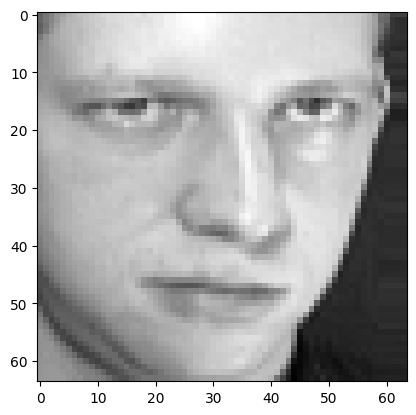

In [ ]:
# Let's test the model

def test_model(index: int, data_X: np.ndarray, data_y: np.ndarray, model, cmap="gray"):
  plt.imshow(data_X[index], cmap=cmap)
  print(f"ML Model's Prediction: {model.predict(data_X[index])}")
  print(f"Correct Answer: {data_y[index]}")

def test_tf_model(index: int, data_X: np.ndarray, data_y: np.ndarray, model, cmap="gray"):
  plt.imshow(data_X[index], cmap=cmap)
  print(f"ML Model's Prediction: {model.predict([data_X[index]])}")
  print(f"Correct Answer: {data_y[index]}")


INDEX_OF_FACE_YOU_WANT_TO_SEE = 4
test_model(INDEX_OF_FACE_YOU_WANT_TO_SEE, X_train, y_train, model_clf)

ML Model's Prediction: [6]
Correct Answer: 6


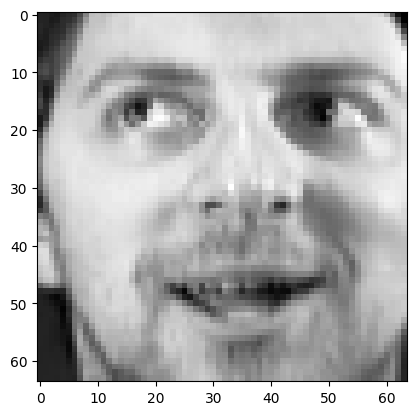

In [ ]:
# The model seems to be doing pretty good, but can it stand data it hasn't seen before?

INDEX_OF_FACE_YOU_WANT_TO_SEE = 6
test_model(INDEX_OF_FACE_YOU_WANT_TO_SEE, X_val, y_val, model_clf)

In [ ]:
# Model Results
# These are some metrics that tell you how BAD the model is! The lower they are, the better!
#from keras.metrics import sparse_categorical_crossentropy

#print(f"Train Loss: {sparse_categorical_crossentropy(tf.constant(y_train, dtype=tf.float32), tf.constant(model.predict(X_train), dtype=tf.float32), from_logits=False)}")

#print(f"Validation Loss: {sparse_categorical_crossentropy(tf.constant(y_val), tf.squeeze(model.predict(X_val)))}")
#print(f"Test Loss: {sparse_categorical_crossentropy(tf.constant(y_test), tf.squeeze(model.predict(X_test)))}")

#print(f"Train Loss: {sparse_categorical_crossentropy(tf.constant(y_train), tf.squeeze(model.predict(X_train)))}")
#print(f"Validation Loss: {sparse_categorical_crossentropy(tf.constant(y_val), tf.squeeze(model.predict(X_val)))}")
#print(f"Test Loss: {sparse_categorical_crossentropy(tf.constant(y_test), tf.squeeze(model.predict(X_test)))}")

### Using a Neural Network

Epoch 1/100
2/2 [==============================] - 3s 698ms/step - loss: 35.4571 - sparse_categorical_accuracy: 0.0219 - val_loss: 315.8027 - val_sparse_categorical_accuracy: 0.0750
Epoch 2/100
2/2 [==============================] - 2s 489ms/step - loss: 107.1474 - sparse_categorical_accuracy: 0.2375 - val_loss: 445.0920 - val_sparse_categorical_accuracy: 0.0250
Epoch 3/100
2/2 [==============================] - 2s 764ms/step - loss: 89.2948 - sparse_categorical_accuracy: 0.3844 - val_loss: 313.7830 - val_sparse_categorical_accuracy: 0.0250
Epoch 4/100
2/2 [==============================] - 2s 507ms/step - loss: 108.1213 - sparse_categorical_accuracy: 0.4031 - val_loss: 171.9574 - val_sparse_categorical_accuracy: 0.0500
Epoch 5/100
2/2 [==============================] - 2s 504ms/step - loss: 69.2521 - sparse_categorical_accuracy: 0.5500 - val_loss: 132.6048 - val_sparse_categorical_accuracy: 0.0500
Epoch 6/100
2/2 [==============================] - 2s 484ms/step - loss: 29.0358 - spars

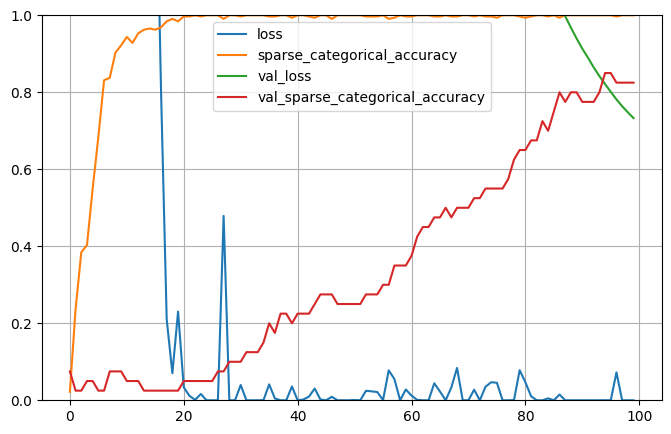

In [ ]:
import math
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Reshape, Dense, Activation, ReLU, BatchNormalization, AlphaDropout
from keras.layers import Conv2D, SeparableConv2D, Activation, BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import SparseCategoricalAccuracy

def noisify_activation(x, amp=0.125, freq=math.e):
    return x + (amp * tf.math.sin(tf.math.exp(freq) * x))

model_nn_clf = Sequential([
    Input(shape=(IMG_DIM, IMG_DIM)),
    Flatten(),

    BatchNormalization(),

    Dense(IMG_DIM*IMG_DIM, kernel_initializer="he_uniform", use_bias=False, activation="linear"),  # an encoding
    BatchNormalization(),

    Reshape((IMG_DIM, IMG_DIM, 1)),

    SeparableConv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), depthwise_initializer="he_normal", use_bias=False),
    BatchNormalization(),
    ReLU(),

    SeparableConv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), depthwise_initializer="he_normal", use_bias=False),
    BatchNormalization(),
    ReLU(),

    Flatten(),

    #AlphaDropout(0.25),
    Activation(noisify_activation),

    Dense(NUM_CLASSES, activation="linear")
])

model_nn_clf.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=Adam(learning_rate=0.01),
                     metrics=[SparseCategoricalAccuracy()])

n_epoch = 100
minibatch_size = 256

#iterations_per_epoch = 1 + (m_train // minibatch_size)
#n_iter = iterations_per_epoch * n_epoch

model_history = model_nn_clf.fit(X_train, y_train, batch_size=minibatch_size, epochs=n_epoch,
                                 validation_data=(X_val, y_val),
                                 callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# Plot history
pd.DataFrame(model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Epoch 1/100
2/2 [==============================] - 2s 543ms/step - loss: 3.7253e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.7206 - val_sparse_categorical_accuracy: 0.8250
Epoch 2/100
2/2 [==============================] - 2s 491ms/step - loss: 3.3155e-08 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.7104 - val_sparse_categorical_accuracy: 0.8250
Epoch 3/100
2/2 [==============================] - 2s 494ms/step - loss: 2.9432e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.7021 - val_sparse_categorical_accuracy: 0.8250
Epoch 4/100
2/2 [==============================] - 2s 478ms/step - loss: 5.9605e-09 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.8250
Epoch 5/100
2/2 [==============================] - 2s 649ms/step - loss: 4.1723e-08 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.6868 - val_sparse_categorical_accuracy: 0.8250
Epoch 6/100
2/2 [==============================] - 2s 503ms/step - loss: 7.4505e-08 -

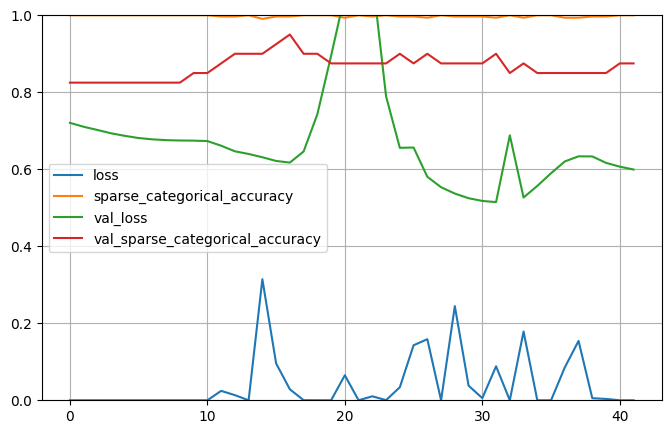

In [ ]:
# fit more because it was doing so well
model_history = model_nn_clf.fit(X_train, y_train, batch_size=minibatch_size, epochs=n_epoch,
                                 validation_data=(X_val, y_val),
                                 callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# Plot history
pd.DataFrame(model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
X_train.shape

(320, 64, 64)

# Face Generation

In [ ]:
def sample_gmm(gaussian_mixture_model, num_samples: int):
  X_new, y_new = gaussian_mixture_model.sample(num_samples)

  return X_new.reshape(num_samples, IMG_DIM, IMG_DIM)

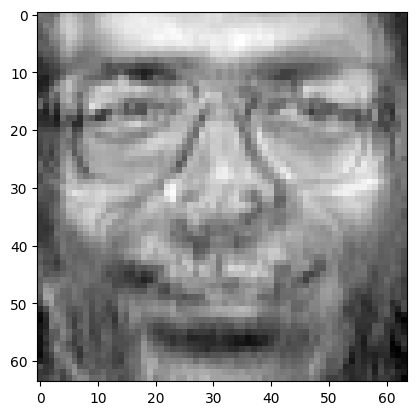

In [ ]:
from sklearn.mixture import GaussianMixture


populations = 40  # clusters
gmm = GaussianMixture(n_components=populations, n_init=10)
gmm.fit(X)  # fit the clusters and create gaussian distributions for each of them

gmm.weights_      # populations weights, calculated by expectation maximization algorithm

# Gaussian Distributions
gmm.means_        # populations means
gmm.covariances_  # populations covariations

# EM
gmm.converged_   # True
gmm.n_iter_      # How many iterations did it take to converge?

# Get the clusters from EM
gmm.predict(X)        # Hard Clustering
gmm.predict_proba(X)  # Soft Clustering (confidences, but the official term is responsibilities)

# Sampling from the GMM
# GMM is a Generative Model!
X_new = sample_gmm(gmm, 5)
plt.imshow(X_new[0], cmap="gray")

In [ ]:
# Now, test what images come out by sampling!

X_new = sample_gmm(gmm, 5)
plt.imshow(X_new[0], cmap="gray")

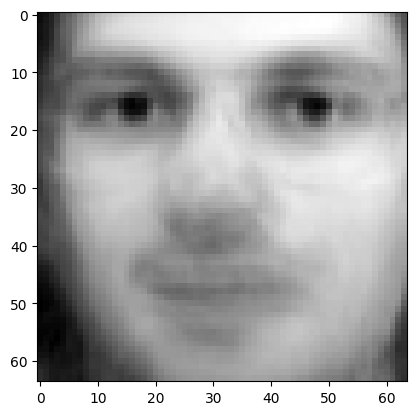

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

# BayesianGaussianMixture will use Bayesian Search Techniques to find the best number of clusters, weights, means, and variances
populations_guess = 40  # populations = clusters
bgmm = BayesianGaussianMixture(n_components=populations_guess, n_init=10)
bgmm.fit(X)

X_new_bayes = sample_gmm(bgmm, 5)
plt.imshow(X_new_bayes[0], cmap="gray")

In [ ]:
# Now, test what images come out by sampling!

X_new_bayes = sample_gmm(bgmm, 5)
plt.imshow(X_new_bayes[0], cmap="gray")

Congratulations! You have successfully generated your own faces!